In [1]:
from mnist import MNIST 
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [2]:
labels = mndata.train_labels

cluster_size = 10
train_inputs_idx = []
for idx in range(10):
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

100

# TODO: Winner's stats synapse.
# TODO: Bio_hebbian stats synapse.
# TODO: Stats synapse for each rez.synapse, not only for winners.
# TODO: Stats synapse for winners and second after winner.
# TODO: Push stats synapses.
# TODO: Rezonanse synapse via avg(or meadian) input.

In [16]:
layer_size = 10*4
c = 4

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
WC = np.ones((O.shape)) # winner's counter
W = np.random.rand(O.size, I.size) * 0.001
S = np.ones((O.size, I.size))
print('W', W.shape, W.max(), W.min(), np.median(W))
print('S', S.shape, S.max(), S.min(), np.median(S))

push_delta = 0.4
k = 1

prec = 1e-30

epoch_cnt = 100
eps0 = 0.02

lr = 0.085

tr_S = 0.01

dec_S = 0.01
inc_S = 0.05

for epoch_idx in range(epoch_cnt):
    eps = (epoch_cnt - epoch_idx) * eps0

    for i_idx in samples_idx:
        img = mndata.train_images[i_idx]

        # infer
        I = np.array(img) / 255
        # DO = 1 / np.exp(np.abs(I*c - W)**2)
        # DO = 1 - np.abs(I*2 - W)
        DO = np.exp((W - I)**2 * -20.0)
        SO = DO * (S / WC[np.newaxis].T)
        # SO[np.where(S < 0)] = 0
        O = np.sum(SO, axis=1)
        # print('O', O.shape, O.max(), O.min(), np.median(O))

        # train
        # dW = (I - W) * O[np.newaxis].T
        # dW = np.sign(I * c - W) * (1 - DO) * O[np.newaxis].T
        # dW = (I - (W/c)) * 1e-2 * O[np.newaxis].T
        # print('dW', dW.shape, dW.max(), dW.min(), np.median(dW))

        winner_ids = np.argsort(O)[::-1]

        D = np.zeros(O.shape)
        D[winner_ids[0]] = 1
        D[winner_ids[1:1+k]] = -push_delta
        D = D[np.newaxis].T

        WC += 1

        # train S
        dS = np.zeros(S.shape)
        # dS[np.where(DO < tr_S)] = -dec_S
        dS[np.where(DO >= tr_S)] = 1

        # update S
        S += dS
        # norm S
        # S /= np.max(np.abs(S))

        # update
        # dW_nc = np.abs(np.max(dW))
        # if dW_nc < prec:
        #     dW_nc = prec
        # dW = dW / np.abs(np.max(dW))
        # ws[:, winner] * (1 - lr) + x * lr
        O /= np.max(np.abs(O))
        O = O[np.newaxis].T
        update_ids = winner_ids[:1+k]
        # print(update_ids, W[update_ids].shape, I[update_ids].shape, dW[update_ids].shape)
        W[update_ids] = W[update_ids] * (1 - lr) + (I * lr * D[update_ids] * O[update_ids])

print('W', W.shape, W.max(), W.min(), np.median(W))
print('S', S.shape, S.max(), S.min(), np.median(S))
SWC = (S/WC[np.newaxis].T)
print('S/WC', SWC.shape, SWC.max(), SWC.min(), np.median(SWC))


W (40, 784) 0.0009999796972999244 1.8534199029973665e-09 0.0004998246141072345
S (40, 784) 1.0 1.0 1.0
W (40, 784) 0.9997509945472354 -0.39586152420418474 2.1912994205096176e-12
S (40, 784) 10001.0 685.0 9701.0
S/WC (40, 784) 1.0 0.0684931506849315 0.97000299970003


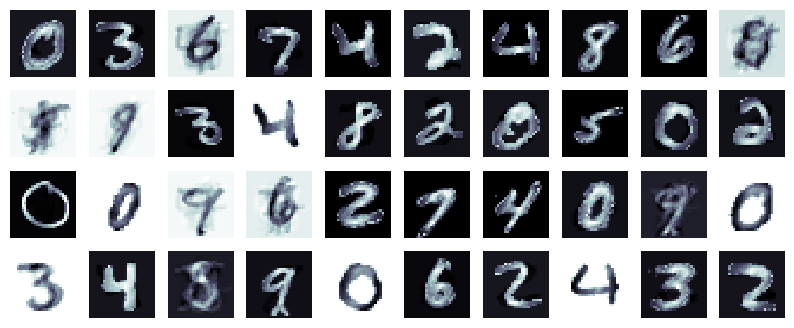

In [18]:
row_size = 10
col_size = int(layer_size / row_size)

figure(figsize=(row_size, col_size))

SO = W * S
for col_idx in range(col_size):
    for row_idx in range(row_size):
        n_W_idx = col_idx * row_size + row_idx

        aimg = SO[n_W_idx].reshape(img_side, img_side)

        subplot(col_size, row_size, n_W_idx + 1)

        imshow(aimg, interpolation='none', aspect='auto', cmap='bone')
        axis("off")

show()
